In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 2"

In [2]:
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import gc

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    use_fast=True
)

In [4]:
finetuned_model = transformers.AutoModelForCausalLM.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:0")

base_model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:0")

finetuned_compressed_model = transformers.AutoModelForCausalLM.from_pretrained(
    "lmsys/vicuna-7b-v1.5-16k",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
).to("cuda:1")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/libbitsandbytes_cuda122.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/libbitsandbytes_cuda122.so...


/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/bitsandbytes-0.39.1-py3.9.egg/bitsandbytes/cuda_setup/main.py:149: UserWarning: /data/tianle/anaconda3/envs/fastchat did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


[2023-10-10 01:39:25,998] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = load_dataset(
    "allenai/c4", 
    data_dir="en",
    split="train",
    data_files=["c4-train.00000-of-01024.json.gz"]
)

Repo card metadata block was not found. Setting CardData to empty.


In [12]:
class TernaryDiff(nn.Module):
    def __init__(self, base, finetune, quantile=0.66, binary=False):
        super().__init__()
        diff = finetune - base
        # Cannot directly use torch.quantile because the tensor is too large
        if binary:
            threshold = 0
            quantile = diff.float().abs().median()
        else:
            threshold = quantile = diff.float().abs().view(-1).kthvalue(int(diff.numel() * quantile)).values
        ternary_diff = torch.zeros_like(diff)
        ternary_diff[diff > threshold] = 1
        ternary_diff[diff < -threshold] = -1
        print(quantile, (ternary_diff*quantile-diff).abs().mean()/diff.abs().mean())
        
        self.register_buffer("ternary_diff", ternary_diff.T)
        self.register_buffer("base", base.T)
        self.register_parameter("coeff", nn.Parameter(torch.tensor(quantile, dtype=base.dtype, device=base.device)))

    def forward(self, x):
        x = x @ (self.base + self.coeff * self.ternary_diff)
        return x

In [13]:
for name, module in finetuned_compressed_model.named_modules():
    if "mlp" in name or "self_attn" in name:
        for subname, submodule in module.named_children():
            if "proj" in subname:#isinstance(submodule, nn.Linear) or isinstance(submodule, compressedDiff):
                compressed = TernaryDiff(
                    base=base_model.get_submodule(name+'.'+subname).weight,
                    finetune=finetuned_model.get_submodule(name+'.'+subname).weight,
                    quantile=0.55,
                    binary=True
                )
                compressed.to(finetuned_compressed_model.device)
                setattr(module, subname, compressed)

tensor(0.0003, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.6328, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.6328, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5781, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5859, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5586, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5586, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5586, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<

/tmp/ipykernel_1514471/1123998809.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_parameter("coeff", nn.Parameter(torch.tensor(quantile, dtype=base.dtype, device=base.device)))


tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5625, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5664, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5508, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5547, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5703, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5703, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<MedianBackward0>) tensor(0.5625, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<

In [14]:
input_ids = tokenizer.encode("Hello, my dog is cute", add_special_tokens=True, return_tensors="pt")

In [15]:
with torch.inference_mode():
    finetuned_outputs = finetuned_model(input_ids.to(finetuned_model.device))
    finetuned_compressed_outputs = finetuned_compressed_model(input_ids.to(finetuned_compressed_model.device))

In [16]:
logits_diff = finetuned_outputs.logits.float().cpu() - finetuned_compressed_outputs.logits.float().cpu()

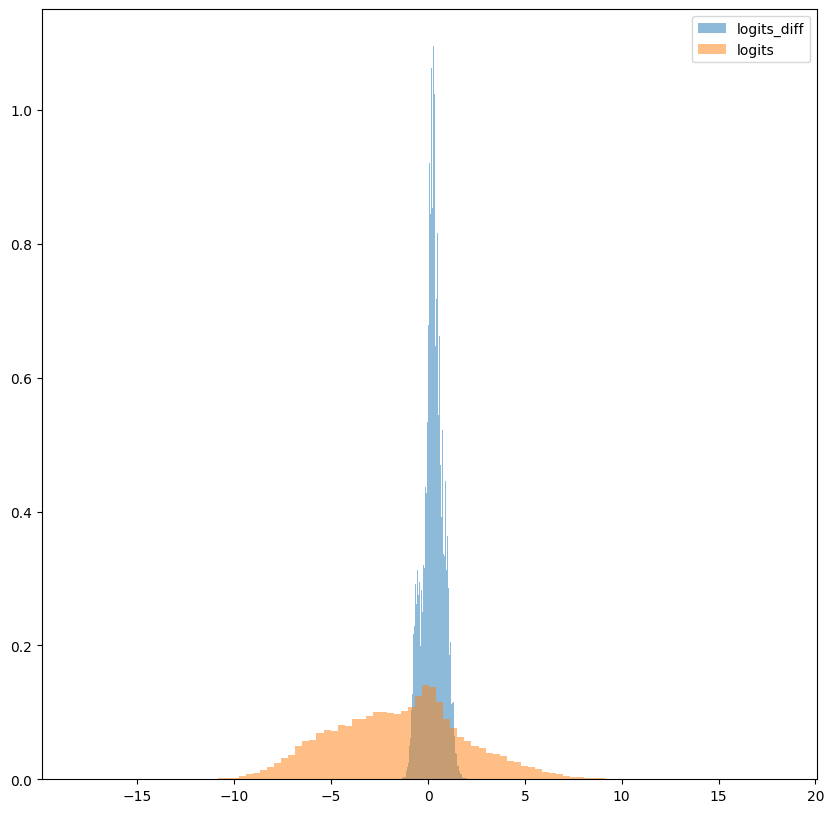

In [17]:
plt.figure(figsize=(10, 10))
_ = plt.hist(logits_diff.numpy().flatten(), bins=100, density=True, alpha=0.5, label="logits_diff")
_ = plt.hist(finetuned_outputs.logits.float().cpu().numpy().flatten(), bins=100, density=True, alpha=0.5, label="logits")

plt.legend()
plt.show()

In [18]:
compressed_params = []
for module in finetuned_compressed_model.modules():
    if isinstance(module, TernaryDiff):
        for param in module.parameters():
            compressed_params.append(param)

In [19]:
loss_list = []
optimizer = torch.optim.AdamW(finetuned_compressed_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
batch_size = 4
for i in range(100):
    batch = [dataset[i]["text"] for i in range(i*batch_size, (i+1)*batch_size)]
    input_ids = tokenizer(batch, add_special_tokens=True, return_tensors="pt", padding=True, truncation=True, max_length=128)["input_ids"]
    with torch.inference_mode():
        finetuned_outputs = finetuned_model(input_ids.to(finetuned_model.device))
    finetuned_compressed_outputs = finetuned_compressed_model(input_ids.to(finetuned_compressed_model.device))
    logits_diff = finetuned_outputs.logits.to(finetuned_compressed_outputs.logits.device) - finetuned_compressed_outputs.logits
    loss = torch.mean(logits_diff**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    print(f"Step {i} Loss: {loss.item()}")
    loss_list.append(loss.item())

Step 0 Loss: 1.036453127861023
Step 1 Loss: 1.1449648141860962
Step 2 Loss: 0.5391293168067932
Step 3 Loss: 0.6512521505355835
Step 4 Loss: 0.31417444348335266
Step 5 Loss: 0.22652138769626617
Step 6 Loss: 0.5894545912742615
Step 7 Loss: 0.3085889518260956
Step 8 Loss: 2.355985403060913
Step 9 Loss: 0.28839001059532166
Step 10 Loss: 0.32323238253593445
Step 11 Loss: 0.7123501300811768
Step 12 Loss: 0.3364121913909912
Step 13 Loss: 0.5326154828071594
Step 14 Loss: 0.28907862305641174
Step 15 Loss: 0.20523013174533844
Step 16 Loss: 0.4371054172515869
Step 17 Loss: 0.6166641116142273
Step 18 Loss: 0.28384724259376526
Step 19 Loss: 0.33203816413879395
Step 20 Loss: 0.4468500018119812
Step 21 Loss: 0.9612035155296326
Step 22 Loss: 0.40951257944107056
Step 23 Loss: 0.27753883600234985
Step 24 Loss: 0.20766380429267883
Step 25 Loss: 0.19375447928905487
Step 26 Loss: 0.436728835105896
Step 27 Loss: 0.6162780523300171
Step 28 Loss: 0.19941407442092896
Step 29 Loss: 1.272966980934143
Step 30 Los

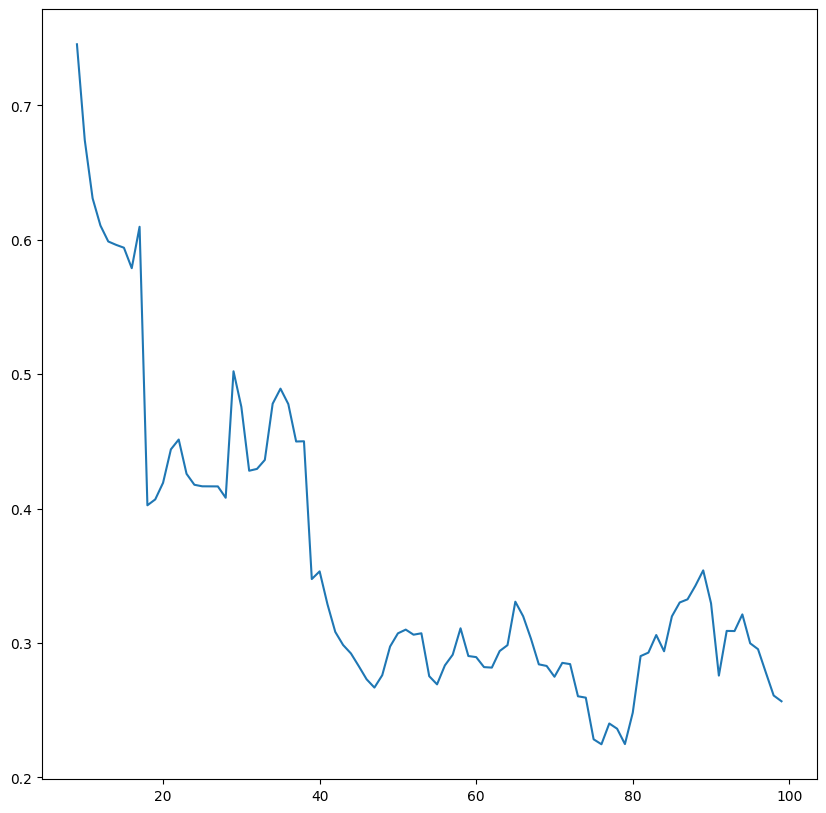

In [20]:
plt.figure(figsize=(10, 10))
# plot smoothed loss
plt.plot(pd.Series(loss_list).rolling(10).mean())

In [21]:
# Update the fine-tuned model with the compressed parameters
finetuned_model_state_dict = finetuned_model.state_dict()

In [22]:
for name, module in finetuned_compressed_model.named_modules():
    if isinstance(module, TernaryDiff):
        finetuned_model_state_dict[name+".weight"] = (module.base + module.coeff * module.ternary_diff).T

In [23]:
finetuned_model.load_state_dict(finetuned_model_state_dict)

<All keys matched successfully>

In [24]:
finetuned_model.save_pretrained(f"vicuna-7b-v1.5-16k-binary")

/data/tianle/anaconda3/envs/fastchat/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:508: UserWarning: The generation config instance is invalid -- `.validate()` throws warnings and/or exceptions. Fix these issues to save the configuration. This warning will be raised to an exception in v4.34.

Thrown during validation:
`do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [25]:
tokenizer.save_pretrained(f"vicuna-7b-v1.5-16k-binary")

('vicuna-7b-v1.5-16k-binary/tokenizer_config.json',
 'vicuna-7b-v1.5-16k-binary/special_tokens_map.json',
 'vicuna-7b-v1.5-16k-binary/tokenizer.model',
 'vicuna-7b-v1.5-16k-binary/added_tokens.json',
 'vicuna-7b-v1.5-16k-binary/tokenizer.json')

In [31]:
finetuned_model_state_dict[name+".weight"].dtype

torch.bfloat16

In [32]:
(module.base + (module.A @ module.B)).T.dtype

torch.bfloat16

In [26]:
finetuned_lora_model_state_dict["model.layers.31.mlp.down_proj.A"].shape

torch.Size([11008, 16])